In [1]:
# 1) DATA IMPORT
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("./data/100_bit_artificial/1a.csv")
X = df.drop(columns="class").to_numpy(bool)
y = df["class"].to_numpy(bool)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (8000, 100), X_test: (2000, 100)
y_train: (8000,), y_test: (2000,)


In [2]:
# 2) TRAIN A NETWORK (RIPPER NODES)
from sklearn.metrics import accuracy_score
from architecture.deep_binary_classifier import DeepBinaryClassifier
from architecture.ripper_node import make_ripper_node
from architecture.utils import truth_table_patterns, truth_table_indices

config = dict(
    layer_node_counts=[32]*5 + [1],
    layer_bit_counts=[6]*6,
    seed=42
)

net = DeepBinaryClassifier(**config, node_factory=make_ripper_node, jobs=8)
_ = net.fit(X_train, y_train)

pred_test = net.predict(X_test)
acc_before = accuracy_score(y_test, pred_test)
print(f"Accuracy (before pruning): {acc_before:.6f}")

Accuracy (before pruning): 0.883000


In [3]:
# 3) DESCRIPTION SYNTAX + HELPERS

from typing import Dict, Tuple, List, Any

NodeKey = Tuple[int, int]  # (layer_number, node_index) with inputs at layer 0

def describe_architecture_graph(net) -> Dict[str, Any]:
    """
    Compact description for drawing/export:
      - 'inputs': sorted list of input indices that reach outputs
      - 'layers': [{'layer': l, 'nodes': [indices]}] with l=0 as input layer
      - 'connections': {(l,i): [prev_indices]}
      - 'node_meta': {(l,i): {'cols': [...], 'bits': int, 'rule': str|None}}
    """
    if not hasattr(net, "layers") or not net.layers:
        raise RuntimeError("Network not fitted; no layers to describe.")

    # 1) Non-input connections (1..L)
    connections: Dict[NodeKey, List[int]] = {
        (l+1, i): node.X_cols.tolist()
        for l, layer in enumerate(net.layers)
        for i, node in enumerate(layer)
    }

    # 2) Backward traversal from final node (assume index 0)
    last_L = len(net.layers)
    stack = [(last_L, 0)]
    visited = set(stack)
    while stack:
        l, i = stack.pop()
        for c in connections.get((l, i), []):
            prev = (l-1, c)
            if prev not in visited:
                visited.add(prev)
                stack.append(prev)

    # 3) Relevant inputs
    relevant_inputs = sorted(j for (l, j) in visited if l == 0)

    # 4) Layers listing
    layers_desc = [{'layer': 0, 'nodes': relevant_inputs}]
    for l, layer in enumerate(net.layers, start=1):
        kept = sorted(i for i, _ in enumerate(layer) if (l, i) in visited)
        layers_desc.append({'layer': l, 'nodes': kept})

    # 5) Filtered connections
    filtered_connections = {k: v for k, v in connections.items() if k in visited}

    # 6) Node metadata
    node_meta: Dict[NodeKey, Dict[str, Any]] = {}
    for l, layer in enumerate(net.layers, start=1):
        for i, node in enumerate(layer):
            if (l, i) not in visited:
                continue
            meta = {
                'cols': node.X_cols.tolist(),
                'bits': int(node.X_cols.size),
            }
            if hasattr(node, "get_ruleset"):
                try:
                    meta['rule'] = node.get_ruleset(disjunction_str=' V ')
                except Exception:
                    meta['rule'] = None
            node_meta[(l, i)] = meta

    return {
        'inputs': relevant_inputs,
        'layers': layers_desc,
        'connections': filtered_connections,
        'node_meta': node_meta
    }

def print_architecture_summary(desc: Dict[str, Any]) -> None:
    print("Inputs used:", desc['inputs'])
    print("Layers:")
    for layer in desc['layers']:
        l = layer['layer']
        nodes = layer['nodes']
        print(f"  L{l}: {len(nodes)} node(s) -> {nodes}")
    print(f"Connections: {len(desc['connections'])} nodes with incoming edges")

In [4]:
# 4) VISUALIZATION OF ARCHITECTURE (NETWORKX)

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def to_networkx_from_description(desc):
    G = nx.DiGraph()
    pos = {}

    # Per-layer nodes
    layer_nodes = {block['layer']: list(block['nodes']) for block in desc['layers']}

    # Position nodes
    for l in sorted(layer_nodes.keys()):
        indices = layer_nodes[l]
        if not indices:
            continue
        ys = np.linspace(0, -1, len(indices))
        for y, idx in zip(ys, indices):
            label = f"{l}-{idx}"
            G.add_node(label)
            pos[label] = (l, y)

    # Edges
    for (l, i), cols in desc['connections'].items():
        to_label = f"{l}-{i}"
        for c in cols:
            from_label = f"{l-1}-{c}"
            if from_label in G and to_label in G:
                G.add_edge(from_label, to_label)

    return G, pos

def draw_architecture(desc, title="DeepBinaryClassifier Architecture"):
    G, pos = to_networkx_from_description(desc)
    node_colors = ['skyblue' if int(n.split('-')[0]) == 0 else 'lightgray' for n in G.nodes()]

    plt.figure(figsize=(9, 5))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=node_colors,
        node_size=600,
        font_size=9,
        edge_color='k'
    )
    plt.title(title)
    plt.axis('off')
    plt.show()


In [5]:
# 4) VISUALIZATION OF ARCHITECTURE (NETWORKX)

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def to_networkx_from_description(desc):
    G = nx.DiGraph()
    pos = {}

    # Per-layer nodes
    layer_nodes = {block['layer']: list(block['nodes']) for block in desc['layers']}

    # Position nodes
    for l in sorted(layer_nodes.keys()):
        indices = layer_nodes[l]
        if not indices:
            continue
        ys = np.linspace(0, -1, len(indices))
        for y, idx in zip(ys, indices):
            label = f"{l}-{idx}"
            G.add_node(label)
            pos[label] = (l, y)

    # Edges
    for (l, i), cols in desc['connections'].items():
        to_label = f"{l}-{i}"
        for c in cols:
            from_label = f"{l-1}-{c}"
            if from_label in G and to_label in G:
                G.add_edge(from_label, to_label)

    return G, pos

def draw_architecture(desc, title="DeepBinaryClassifier Architecture"):
    G, pos = to_networkx_from_description(desc)
    node_colors = ['skyblue' if int(n.split('-')[0]) == 0 else 'lightgray' for n in G.nodes()]

    plt.figure(figsize=(9, 5))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=node_colors,
        node_size=600,
        font_size=9,
        edge_color='k'
    )
    plt.title(title)
    plt.axis('off')
    plt.show()


In [6]:
# 5) PRUNER (IN-PLACE)

def prune_network(
        net,
        outputs_to_keep=None,
        verbose: bool = True,
) -> None:
    """
    Keep only nodes contributing to selected final outputs; reindex X_cols accordingly.
    """
    import numpy as np

    if not hasattr(net, "layers") or not net.layers:
        raise RuntimeError("Cannot prune: the network has no layers. Did you call fit()?")

    n_layers = len(net.layers)
    if outputs_to_keep is None:
        outputs_to_keep = {0}
    else:
        outputs_to_keep = set(int(i) for i in outputs_to_keep)

    if verbose:
        before = [len(L) for L in net.layers]
        print(f"Before pruning: {before}")

    keep = [set() for _ in range(n_layers)]
    last_count = len(net.layers[-1])
    for i in outputs_to_keep:
        if i < 0 or i >= last_count:
            raise IndexError(f"outputs_to_keep index {i} out of range for final layer of size {last_count}")
    keep[-1] = set(outputs_to_keep)

    for L in range(n_layers - 1, 0, -1):
        prev_size = len(net.layers[L - 1])
        for j in keep[L]:
            node = net.layers[L][j]
            for prev_idx in node.X_cols:
                pi = int(prev_idx)
                if pi < 0 or pi >= prev_size:
                    raise IndexError(
                        f"Layer {L} node {j} references invalid prev index {pi} (prev layer size {prev_size})"
                    )
                keep[L - 1].add(pi)

    index_maps = []
    for L in range(n_layers):
        survivors = sorted(keep[L])
        if not survivors:
            raise RuntimeError(f"Pruning resulted in empty layer {L}.")
        mapper = {old: new for new, old in enumerate(survivors)}
        index_maps.append(mapper)
        net.layers[L] = [net.layers[L][old] for old in survivors]

    for L in range(1, n_layers):
        prev_map = index_maps[L - 1]
        for node in net.layers[L]:
            node.X_cols = np.array([prev_map[int(c)] for c in node.X_cols], dtype=int)

    if verbose:
        after = [len(L) for L in net.layers]
        print(f"After pruning:  {after}")


=== BEFORE PRUNING ===
Inputs used: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 20, 21, 23, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 55, 56, 60, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 91, 93, 94, 95, 96, 98]
Layers:
  L0: 77 node(s) -> [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 20, 21, 23, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 55, 56, 60, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 91, 93, 94, 95, 96, 98]
  L1: 32 node(s) -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
  L2: 31 node(s) -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
  L3: 29 node(s) -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,

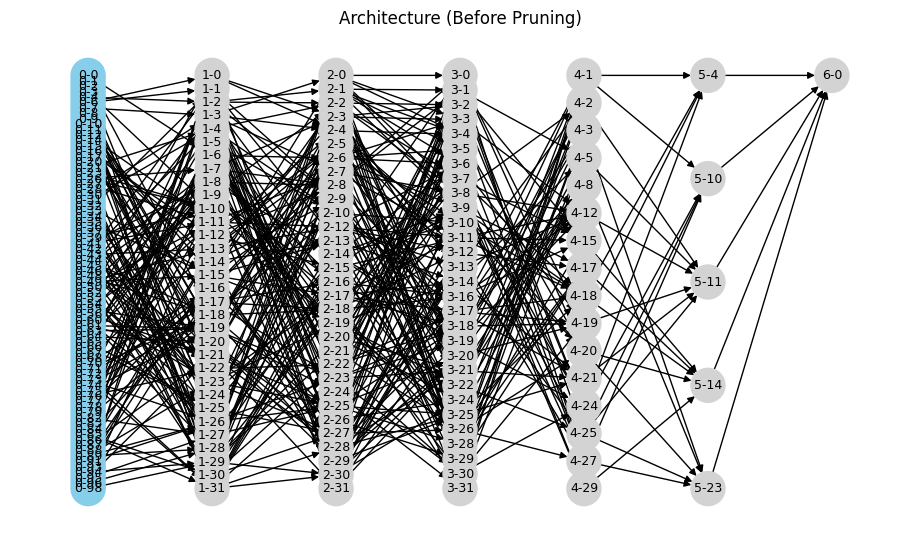

Before pruning: [32, 32, 32, 32, 32, 1]
After pruning:  [32, 31, 29, 16, 5, 1]

=== AFTER PRUNING ===
Inputs used: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 20, 21, 23, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 55, 56, 60, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 91, 93, 94, 95, 96, 98]
Layers:
  L0: 77 node(s) -> [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 20, 21, 23, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 55, 56, 60, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 91, 93, 94, 95, 96, 98]
  L1: 32 node(s) -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
  L2: 31 node(s) -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,

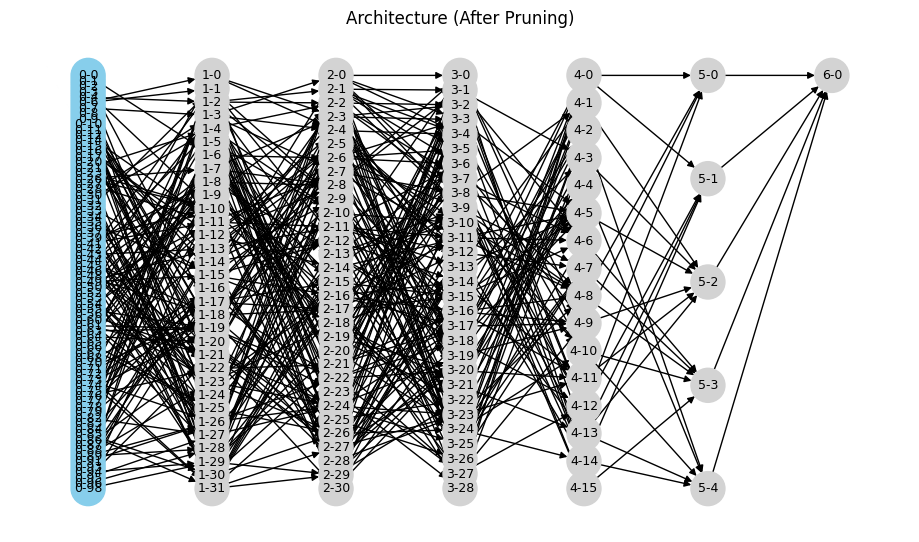


Accuracy (after pruning):  0.883000
Δ accuracy: 0.0

Final layer L=6, nodes: [0]
Sample node meta at L=6, i=0 -> {'cols': [2, 1, 4, 3, 0], 'bits': 5, 'rule': '[x_11=True^x_10=True^x_23=True] V [x_11=True^x_10=True] V [x_11=True^x_14=True] V [x_23=True^x_4=True] V [x_23=True] V [x_10=True]'}


In [7]:
# 6) EXECUTE INSPECTION + PRUNING + RE-INSPECTION

from sklearn.metrics import accuracy_score

print("=== BEFORE PRUNING ===")
desc_before = describe_architecture_graph(net)
print_architecture_summary(desc_before)
draw_architecture(desc_before, title="Architecture (Before Pruning)")

prune_network(net, outputs_to_keep={0}, verbose=True)

print("\n=== AFTER PRUNING ===")
desc_after = describe_architecture_graph(net)
print_architecture_summary(desc_after)
draw_architecture(desc_after, title="Architecture (After Pruning)")

pred_test_pruned = net.predict(X_test)
acc_after = accuracy_score(y_test, pred_test_pruned)
print(f"\nAccuracy (after pruning):  {acc_after:.6f}")
print("Δ accuracy:", float(acc_after - acc_before))

# Optional: peek into some nodes before/after (indices may differ post-prune)
try:
    # show a deep node's metadata after pruning
    final_layer = max(layer['layer'] for layer in desc_after['layers'])
    deep_nodes = desc_after['layers'][-1]['nodes']
    print(f"\nFinal layer L={final_layer}, nodes: {deep_nodes}")
    if deep_nodes:
        key = (final_layer, deep_nodes[0])
        meta = desc_after['node_meta'].get(key, {})
        print(f"Sample node meta at L={final_layer}, i={deep_nodes[0]} -> {meta}")
except Exception as e:
    print(f"(Node meta preview skipped: {e})")


In [9]:
# 7) RIPPER RULE-TREE — QUINE–MCCLUSKEY MINIMIZATION

from itertools import combinations, chain
from typing import Optional, Tuple

def _int_to_bits(i: int, n: int) -> Tuple[int, ...]:
    return tuple((i >> k) & 1 for k in reversed(range(n)))  # big-endian

def _combine_implicants(a, b):
    """
    Combine two implicants if they differ in exactly one position.
    Each implicant is a tuple of {0,1,None}.
    Returns combined implicant or None.
    """
    diff = 0
    combined = []
    for x, y in zip(a, b):
        if x == y:
            combined.append(x)
        elif x is None or y is None:
            return None  # don't combine if one has don't-care and other is value (keeps standard Q-M)
        else:
            diff += 1
            combined.append(None)
            if diff > 1:
                return None
    return tuple(combined) if diff == 1 else None

def _covers(imp, m):
    """Does implicant imp cover minterm m? imp: tuple in {0,1,None}, m: tuple in {0,1}."""
    return all((i is None) or (i == mi) for i, mi in zip(imp, m))

def quine_mccluskey(minterms: List[int], nbits: int) -> List[Tuple[Optional[int], ...]]:
    """
    Return a minimal cover (list of implicants) for the given minterms using Q-M + exact cover.
    Each implicant is a tuple of {0,1,None} of length nbits.
    """
    if len(minterms) == 0:
        return []  # constant False
    if len(minterms) == (1 << nbits):
        return [(None,) * nbits]  # constant True

    # Initial implicants from minterms
    groups = {}
    minterm_bits = {m: _int_to_bits(m, nbits) for m in minterms}
    for m, bits in minterm_bits.items():
        groups.setdefault(sum(bits), set()).add(bits)

    # Iterative combining
    prime_implicants = set()
    while groups:
        next_groups = {}
        used = set()
        keys = sorted(groups.keys())
        for i in range(len(keys) - 1):
            g1, g2 = keys[i], keys[i+1]
            for a in groups[g1]:
                for b in groups[g2]:
                    c = _combine_implicants(a, b)
                    if c is not None:
                        next_groups.setdefault(sum(v for v in c if v == 1), set()).add(c)
                        used.add(a); used.add(b)
        # add unused to primes
        for g in keys:
            for a in groups[g]:
                if a not in used:
                    # cast to implicant with None allowed
                    prime_implicants.add(tuple(a))
        # deduplicate next_groups
        groups = {}
        for k, vs in next_groups.items():
            dedup = set(vs)
            groups[k] = dedup

    # Expand primes to include Nones (they're already tuples with None where combined)
    primes = set()
    for p in prime_implicants:
        # Ensure Nones exist where implied by combination; tuples already fine
        primes.add(tuple(None if (v is None) else int(v) for v in p))

    # Prime implicant chart
    minterm_set = set(minterms)
    prime_list = list(primes)
    covers = {i: set() for i in minterm_set}
    for idx, imp in enumerate(prime_list):
        for m, bits in minterm_bits.items():
            if _covers(imp, bits):
                covers[m].add(idx)

    # Essential primes
    essential_idxs = set()
    for m, idxs in covers.items():
        if len(idxs) == 1:
            essential_idxs |= idxs
    covered = set()
    for m, idxs in covers.items():
        if idxs & essential_idxs:
            covered.add(m)

    remaining_minterms = sorted(minterm_set - covered)
    remaining_primes = [i for i in range(len(prime_list)) if i not in essential_idxs]

    # If still uncovered, exact cover by small search; otherwise done
    chosen_idxs = set(essential_idxs)
    if remaining_minterms:
        # Reduce candidate primes to those that cover any remaining minterm
        candidate_idxs = sorted(
            {pi for m in remaining_minterms for pi in covers[m]} - chosen_idxs
        )

        # Exact cover via increasing subset size (nbits is small -> tractable)
        success = False
        for r in range(1, len(candidate_idxs) + 1):
            for combo in combinations(candidate_idxs, r):
                covered_now = set()
                for pi in combo:
                    # add coverage of this prime
                    for m in remaining_minterms:
                        if pi in covers[m]:
                            covered_now.add(m)
                if len(covered_now) == len(remaining_minterms):
                    chosen_idxs |= set(combo)
                    success = True
                    break
            if success:
                break
        if not success:
            # Greedy fallback (should rarely trigger)
            uncovered = set(remaining_minterms)
            for pi in candidate_idxs:
                newly = {m for m in uncovered if pi in covers[m]}
                if newly:
                    chosen_idxs.add(pi)
                    uncovered -= newly
                if not uncovered:
                    break

    implicants = [prime_list[i] for i in sorted(chosen_idxs)]
    return implicants

def implicants_to_terms(implicants, feature_order: List[int]):
    """
    Convert implicants to DNF terms: each term is list[(feature_col, value)].
    feature_order: list of original column indices in the local node (node.X_cols order).
    """
    terms = []
    n = len(feature_order)
    for imp in implicants:
        term = []
        for k, v in enumerate(imp):
            if v is None:
                continue
            term.append((feature_order[k], int(v)))
        terms.append(term)
    return terms

def pretty_dnf(terms, feature_prefix="x_", negate_symbol="¬"):
    """
    Human-readable DNF: disjunction of conjunctions.
    """
    if terms is True:
        return "TRUE"
    if terms is False or len(terms) == 0:
        return "FALSE"
    parts = []
    for term in terms:
        if not term:
            parts.append("TRUE")
            continue
        lits = []
        for (col, v) in term:
            name = f"{feature_prefix}{col}"
            lits.append(name if v == 1 else f"{negate_symbol}{name}")
        parts.append("(" + " ∧ ".join(lits) + ")")
    return " V ".join(parts)

def ripper_node_truth_minterms(node):
    """
    For RipperNode: return (nbits, feature_order, positive_minterms).
    Uses node.pred_node (precomputed truth-table predictions over node.X_cols).
    """
    if not hasattr(node, "pred_node"):
        raise TypeError("Expected a RipperNode with a stored pred_node truth table.")
    nbits = len(node.X_cols)
    positives = [i for i, v in enumerate(node.node_predictions) if bool(v)]
    feature_order = list(node.X_cols)  # local bit position -> original column
    return nbits, feature_order, positives

def build_rule_tree_terms_for_node(node):
    """
    Compute minimal DNF terms for a RipperNode via Quine–McCluskey.
    """
    nbits, feature_order, minterms = ripper_node_truth_minterms(node)
    implicants = quine_mccluskey(minterms, nbits)
    terms = implicants_to_terms(implicants, feature_order)
    return terms, feature_order


In [10]:
# 8) VISUALIZE RULE TREE (NETWORKX)

def build_rule_trie(terms, feature_order):
    """
    Build a trie merging shared prefixes (ordered by feature_order).
    Node structure: dict with 'label', 'children' (dict{'0':node,'1':node}), 'is_leaf', 'value'
    """
    root = {'label': 'ROOT', 'children': {}, 'is_leaf': False, 'value': None}

    # Map feature -> its order index for consistent sequencing
    order_index = {feat: i for i, feat in enumerate(feature_order)}

    for term in terms:
        # Convert term list[(col, v)] into dict[col] = v
        d = {col: v for (col, v) in term}
        # Traverse only features that appear in the term, in order
        path_feats = [feat for feat in feature_order if feat in d]
        node = root
        for feat in path_feats:
            v = d[feat]
            edge = str(v)
            key = (feat, edge)
            if edge not in node['children']:
                node['children'][edge] = {'label': f"x_{feat}", 'children': {}, 'is_leaf': False, 'value': None}
            node = node['children'][edge]
        # Mark leaf as True
        node['is_leaf'] = True
        node['value'] = True
    return root

def draw_rule_tree(terms, feature_order, title="RIPPER Node Rule Tree"):
    """
    Draw a rule tree (trie) for the DNF terms.
    """
    import networkx as nx
    import matplotlib.pyplot as plt

    if terms is True:
        plt.figure(figsize=(4, 3))
        plt.text(0.5, 0.5, "TRUE", ha='center', va='center')
        plt.title(title)
        plt.axis('off')
        plt.show()
        return
    if terms is False or len(terms) == 0:
        plt.figure(figsize=(4, 3))
        plt.text(0.5, 0.5, "FALSE", ha='center', va='center')
        plt.title(title)
        plt.axis('off')
        plt.show()
        return

    trie = build_rule_trie(terms, feature_order)

    G = nx.DiGraph()
    labels = {}
    edge_labels = {}

    # BFS to build graph
    from collections import deque
    q = deque()
    root_id = "ROOT"
    G.add_node(root_id)
    labels[root_id] = "ROOT"
    q.append((root_id, trie))

    while q:
        nid, nd = q.popleft()
        for edge, child in nd['children'].items():
            cid = f"{nid}/{child['label']}[{edge}]/{id(child)}"
            G.add_node(cid)
            lbl = child['label']
            if child['is_leaf']:
                lbl = lbl + "\n⟶ TRUE"
            labels[cid] = lbl
            G.add_edge(nid, cid)
            edge_labels[(nid, cid)] = edge
            q.append((cid, child))

    # Simple layered layout: split node labels to infer depth
    # For clarity, use spring_layout with fixed seed
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=False, node_size=1200, node_color="lightyellow", edge_color='k')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    plt.title(title)
    plt.axis('off')
    plt.show()


Final node minimal DNF:
(x_1) V (x_4) V (x_2 ∧ x_3)


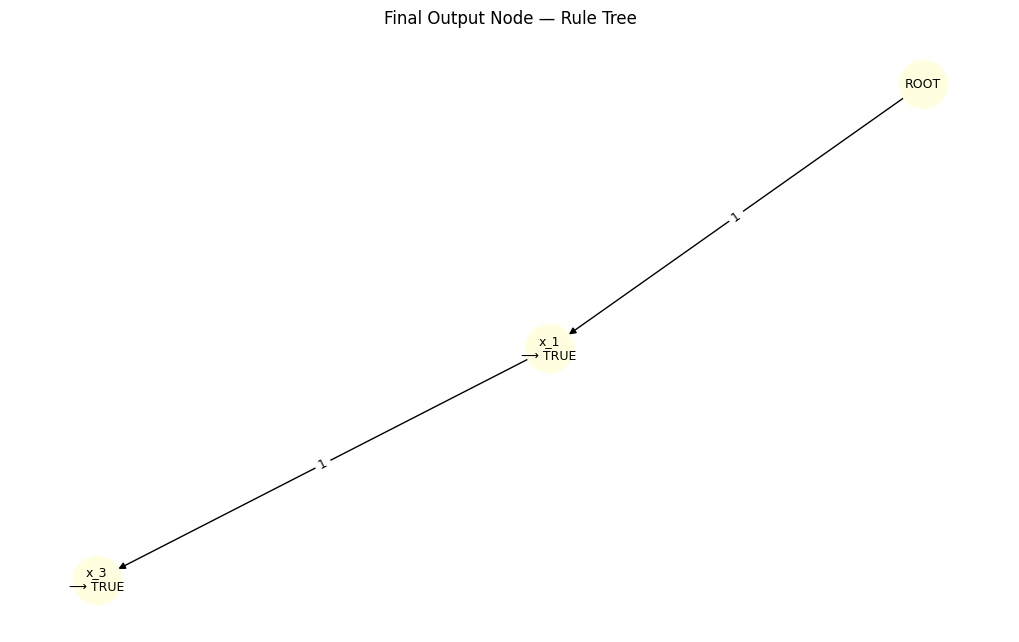

In [11]:
# 9) BUILD + PRINT + VISUALIZE RULE TREE FOR FINAL OUTPUT NODE

# Grab final output node (assumed index 0)
final_node = net.layers[-1][0]

# Compute minimal DNF terms (exact, via node truth table)
terms, feature_order = build_rule_tree_terms_for_node(final_node)

# Pretty print
dnf_str = pretty_dnf(terms)
print("Final node minimal DNF:")
print(dnf_str)

# Visualize tree
draw_rule_tree(terms, feature_order, title="Final Output Node — Rule Tree")


Node (L=5, i=0) minimal DNF:
(x_1) V (x_4) V (x_2 ∧ x_3)


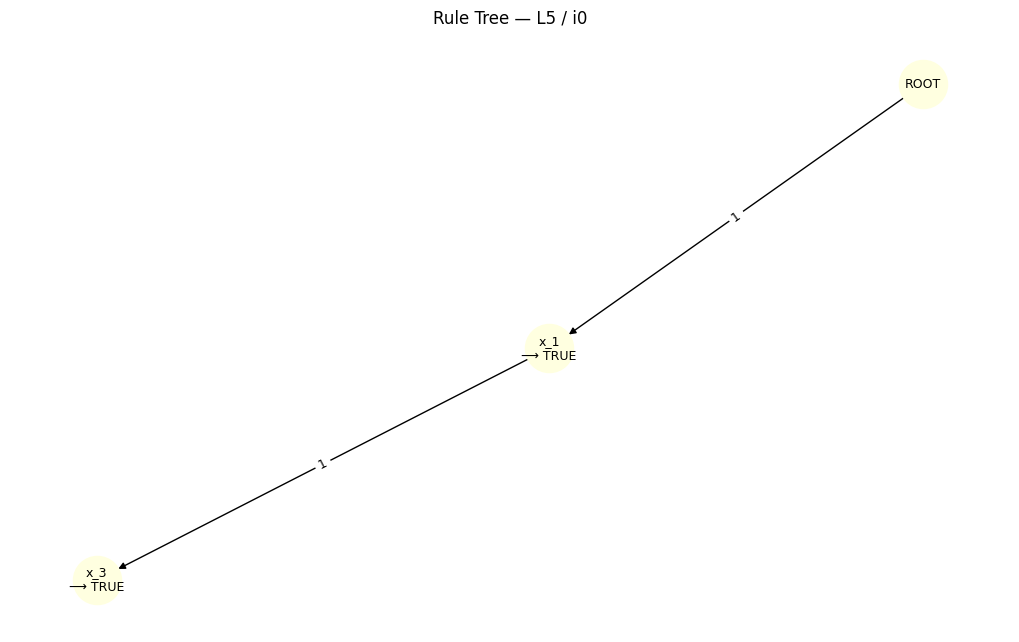

Node (L=4, i=2) minimal DNF:
(x_5) V (x_11 ∧ x_3) V (x_11 ∧ x_9) V (x_1 ∧ ¬x_13)


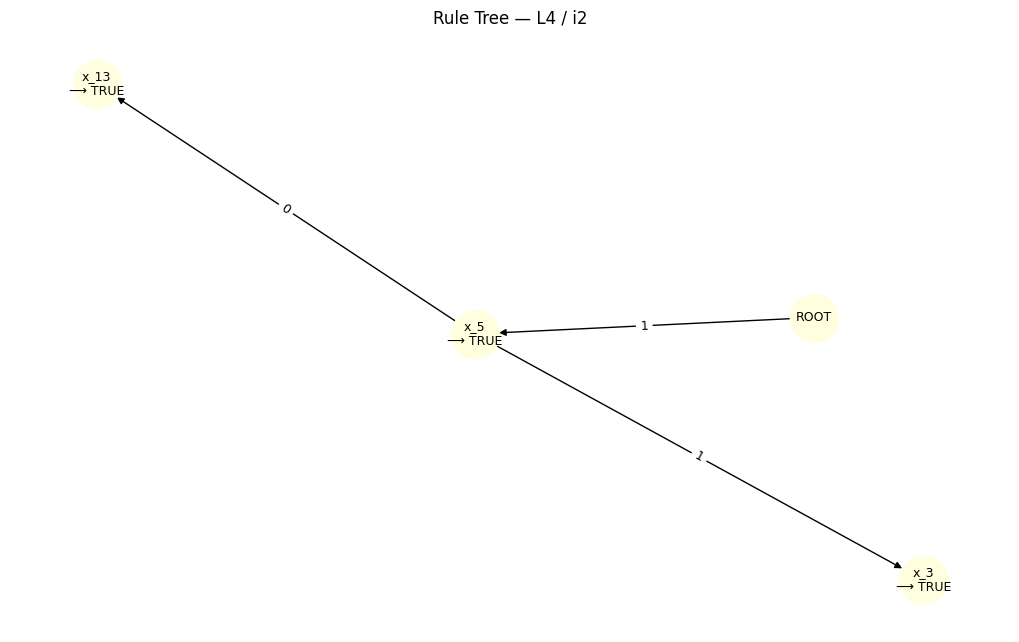

In [12]:
# 10) OPTIONAL: RULE TREES FOR INTERMEDIATE RIPPER NODES

def show_rule_tree_for(net, layer: int, index: int):
    node = net.layers[layer][index]
    terms, feature_order = build_rule_tree_terms_for_node(node)
    print(f"Node (L={layer}, i={index}) minimal DNF:")
    print(pretty_dnf(terms))
    draw_rule_tree(terms, feature_order, title=f"Rule Tree — L{layer} / i{index}")

# Example usage: a node from the penultimate layer if it exists
if len(net.layers) >= 2 and len(net.layers[-2]) > 0:
    show_rule_tree_for(net, len(net.layers)-1, 0)  # same as final (for clarity)
    # try a deeper internal node:
    idx = min(2, len(net.layers[-2]) - 1)
    show_rule_tree_for(net, len(net.layers)-2, idx)
